In [1]:
import os
import cv2
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json
from utils_gen import gen_paths_img_dm, gen_var_from_paths
from utils_imgproc import norm_by_imagenet
%matplotlib inline
plt.ioff()


Using TensorFlow backend.


In [2]:
# Settings
net = 'CASAcrowd'
dataset = 'A'
# Generate paths of (train, test) x (img, dm)
(test_img_paths, train_img_paths), (test_dm_paths, train_dm_paths) = gen_paths_img_dm(
    path_file_root='C:/Users/DEVANSH JAIN/Desktop/ML-AI-DL/collegeproject/data/paths_train_val_test',
    dataset=dataset
)
# Generate raw images(normalized by imagenet rgb) and density maps
test_x, test_y = gen_var_from_paths(test_img_paths[:], unit_len=None), gen_var_from_paths(test_dm_paths[:], stride=8, unit_len=None)
test_x = norm_by_imagenet(test_x)  # Normalization on raw images in test set, those of training set are in image_preprocessing below.
print('Test data size:', test_x.shape[0], test_y.shape[0], len(test_img_paths))
train_x, train_y = gen_var_from_paths(train_img_paths[:], unit_len=None), gen_var_from_paths(train_dm_paths[:], stride=8, unit_len=None)
print('Train data size:', train_x.shape[0], train_y.shape[0], len(train_img_paths))
# Delete the directory for saving weights during last training.
weights_dir = 'weights_' + dataset
if os.path.exists(weights_dir):
    shutil.rmtree(weights_dir)

Test data size: 182 182 182
Train data size: 300 300 300


In [12]:
from keras.optimizers import Adam
from keras.utils import plot_model
from CASAModel import CASAModel

# Create empty directory for saving weights during training
if os.path.exists(weights_dir):
    shutil.rmtree(weights_dir)
os.makedirs(weights_dir)

# Settings of network
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
LOSS = 'MSE'
optimizer = Adam(lr=1e-5)

# Create my model
model = CASAModel(input_shape=(None, None, 3))
model.compile(optimizer=optimizer, loss='MSE')
model.summary()
# if not os.path.exists('models'):
#     os.makedirs('models')
# plot_model(model, 'models/{}.png'.format(net))
# with open('./models/{}.json'.format(net), 'w') as fout:
#     fout.write(model.to_json())

Model: "CASAModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, None, None, 6 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, None, None, 6 36928       conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, None, None, 6 0           conv2d_25[0][0]                  
__________________________________________________________________________________________

In [4]:
from keras.models import model_from_json
net='CASAModel'
if not os.path.exists('models'):
    os.makedirs('models')
# plot_model(model, 'models/{}.png'.format(net))
with open('./models/{}.json'.format(net), 'w') as fout:
    fout.write(model.to_json())

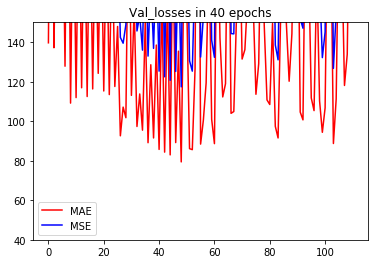

'weights_A_MSE_MAE79.404_Sun-Nov-22'

In [5]:
import sys
import pandas as pd
from time import time, ctime
from utils_imgproc import image_preprocessing
from utils_callback import eval_loss, callbacks_during_train


# Settings of training
batch_size = 1
epoch = 40
val_rate = 0.5
val_rate_dec = {'A': [60, 98], 'B': [8, 12.5]}
len_train = train_x.shape[0]
num_iter = int((len_train-0.1) // batch_size + 1)
best_values = {'mae': 1e5, 'mse': 1e5}
losses = [[1e5, 1e5]]
# Settings of display
dis_idx = 16 if dataset == 'B' else 0
dis_path = test_img_paths[dis_idx]
dis_x = test_x[dis_idx]
dis_y = test_y[dis_idx]
dis_lim = (5, 35) if dataset == 'B' else (40, 150)
time_st = time()

# Training iterations
for ep in range(epoch):
    for idx_train in range(0, len_train, batch_size):
        dis_epoch = str(ep+1)+'-'+str(idx_train+1)+'_'+str(len_train)
        x, y = train_x[idx_train:idx_train+batch_size], train_y[idx_train:idx_train+batch_size]
        # Preprocessings on raw images
        x, y = image_preprocessing(
            x, y,
            flip_hor=True
        )
        model.fit(x, y, batch_size=1, verbose=0)
        idx_val = (idx_train / batch_size + 1)
        # Eval losses and save models
        if idx_val % (num_iter * val_rate) == 0:
            
            loss = eval_loss(model, test_x, test_y, quality=False)
            if loss[0] < val_rate_dec[dataset][0]:
                val_rate = min(val_rate, 0.25)
            if loss[0] < val_rate_dec[dataset][1]:
                val_rate = min(val_rate, 0.1)
            losses.append(loss)
            if (loss[0] < best_values['mae']) or (loss[0] == best_values['mae'] and loss[1] < best_values['mse']):
                model.save_weights(os.path.join(weights_dir, '{}_best.hdf5'.format(net)))
            for idx_best in range(len(loss)):
                if loss[idx_best] < best_values[list(best_values.keys())[idx_best]]:
                    best_values[list(best_values.keys())[idx_best]] = loss[idx_best]
                    to_save = True
            if to_save:
                path_save = os.path.join(weights_dir, ''.join([
                    net,
                    '_MAE', str(round(loss[0], 3)), '_MSE', str(round(loss[1], 3)),
                    '_epoch', str(ep+1), '-', str(idx_val), '.hdf5'
                ]))
                model.save_weights(path_save)
                to_save = False
        # Progress panel
        time_consuming = time() - time_st
        sys.stdout.write('In epoch {}, with MAE-MSE={}, time consuming={}m-{}s\r'.format(
            dis_epoch, np.round(np.array(losses)[-1, :], 2),
            int(time_consuming/60), int(time_consuming-int(time_consuming/60)*60)
        ))
        sys.stdout.flush()

# Save records
losses = np.array(losses[1:])
pd.DataFrame(losses).to_csv('{}/loss.csv'.format(weights_dir), index=False, header=['MAE', 'MSE'])
losses_MAE, losses_MSE = losses[:, 0], losses[:, 1]
plt.plot(losses_MAE, 'r')
plt.plot(losses_MSE, 'b')
plt.legend(['MAE', 'MSE'])
plt.ylim(dis_lim)
plt.title('Val_losses in {} epochs'.format(epoch))
plt.savefig('{}/{}_val_loss.png'.format(weights_dir, net))
plt.show()

# Rename weights_dir by the trainging end time, to prevent the careless deletion or overwriting
end_time_of_train = '-'.join(ctime().split()[:-2])
suffix_new_dir = '_{}_{}_MAE{}_{}'.format(dataset, LOSS, str(round(best_values['mae'], 3)), end_time_of_train)
weights_dir_neo = 'weights'+suffix_new_dir
shutil.move('weights_{}'.format(dataset), weights_dir_neo)

0/182
100/182


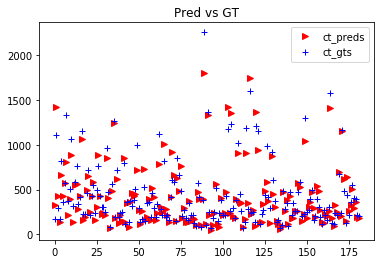

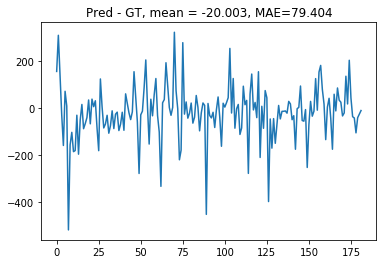

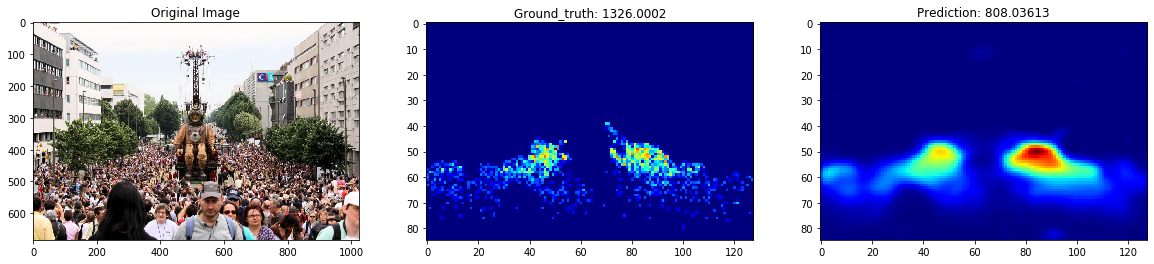

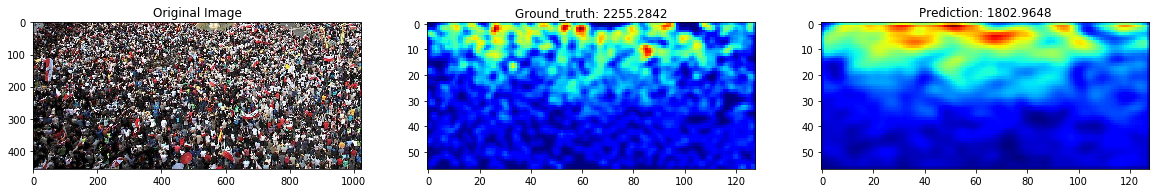

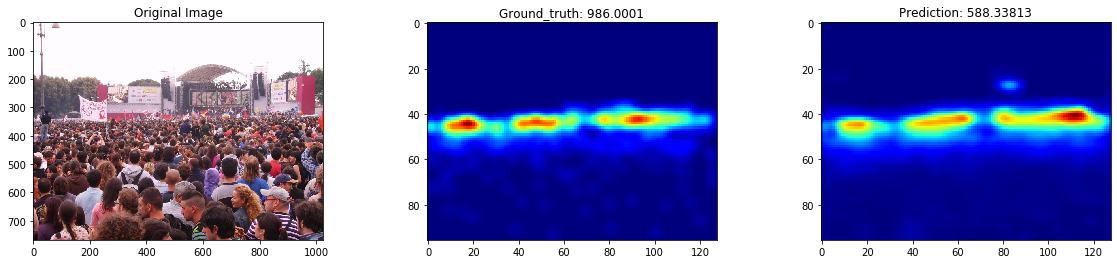

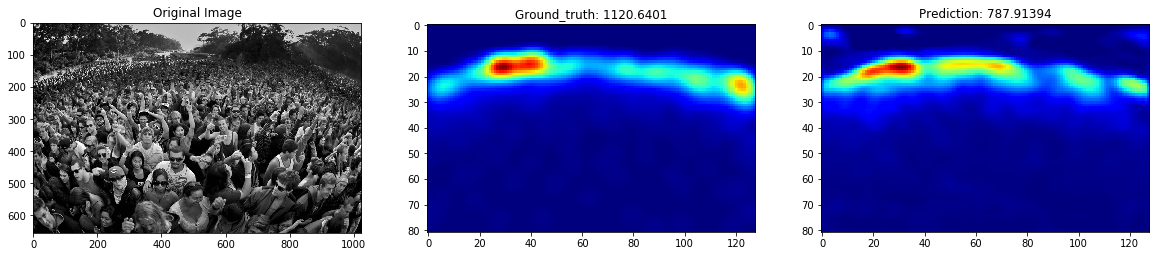

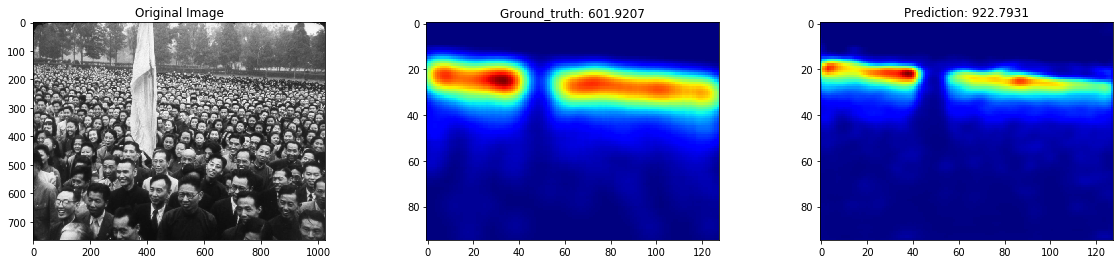

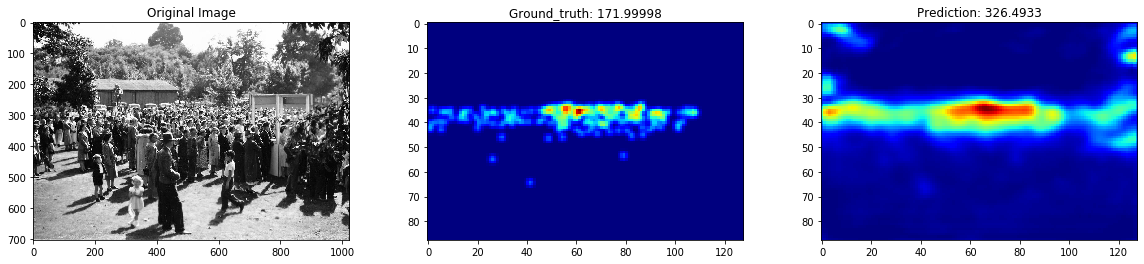

In [6]:
model.load_weights(os.path.join(weights_dir_neo, '{}_best.hdf5'.format(net)))
ct_preds = []
ct_gts = []
for i in range(len(test_x[:])):
    if i % 100 == 0:
        print('{}/{}'.format(i, len(test_x)))
    i += 0
    test_x_display = np.squeeze(test_x[i])
    test_y_display = np.squeeze(test_y[i])
    path_test_display = test_img_paths[i]
    pred = np.squeeze(model.predict(np.expand_dims(test_x_display, axis=0)))
    ct_pred = np.sum(pred)
    ct_gt = round(np.sum(test_y_display))
    ct_preds.append(ct_pred)
    ct_gts.append(ct_gt)
plt.plot(ct_preds, 'r>')
plt.plot(ct_gts, 'b+')
plt.legend(['ct_preds', 'ct_gts'])
plt.title('Pred vs GT')
plt.show()
error = np.array(ct_preds) - np.array(ct_gts)
plt.plot(error)
plt.title('Pred - GT, mean = {}, MAE={}'.format(
    str(round(np.mean(error), 3)),
    str(round(np.mean(np.abs(error)), 3))
))
plt.show()
idx_max_error = np.argsort(np.abs(error))[::-1]

# Show the 5 worst samples
for worst_idx in idx_max_error[:5].tolist() + [dis_idx]:
    test_x_display = np.squeeze(test_x[worst_idx])
    test_y_display = np.squeeze(test_y[worst_idx])
    path_test_display = test_img_paths[worst_idx]
    pred = np.squeeze(model.predict(np.expand_dims(test_x_display, axis=0)))
    fg, (ax_x_ori, ax_y, ax_pred) = plt.subplots(1, 3, figsize=(20, 4))
    ax_x_ori.imshow(cv2.cvtColor(cv2.imread(path_test_display), cv2.COLOR_BGR2RGB))
    ax_x_ori.set_title('Original Image')
    ax_y.imshow(test_y_display, cmap=plt.cm.jet)
    ax_y.set_title('Ground_truth: ' + str(np.sum(test_y_display)))
    ax_pred.imshow(pred, cmap=plt.cm.jet)
    ax_pred.set_title('Prediction: ' + str(np.sum(pred)))
    plt.show()

In [7]:
lossMAE, lossMSE, PSNR, SSIM = eval_loss(
    model, test_x, test_y, quality=True
)
print(lossMAE, lossMSE, PSNR, SSIM)

79.4044 117.368484 20.44750081467964 0.5204489607568936
